<img src="https://thevalley.es/wp-content/uploads/2016/11/thevalley-logo-negro.png" width="400"></img>

# Curso de iniciación de la ciencia de datos espacial (introducción al manejo de información raster)

Ejercicio para la primera toma de contacto con el manejo de información espacial con objetos raster

Notebook por: **Juan Ramón Selva / David Rey**

## ¿Qué es un raster?

Los datos raster se componen de píxeles (también conocidos como celdas de la cuadrícula). Por lo general son cuadradadas y están regularmente espaciadas, pero no tiene por qué. La malla define el espacio geográfico como una matriz de puntos de cuadrícula cuadrados de igual tamaño dispuestos en filas y columnas. Cada punto de la cuadrícula almacena un valor numérico que representa un atributo geográfico (tales como elevación o superficie de la pendiente) para esa unidad de espacio. Cada celda de la malla se referencia por sus coordenadas x e y.

![img](https://desktop.arcgis.com/es/arcmap/10.3/manage-data/raster-and-images/GUID-6754AF39-CDE9-4F9D-8C3A-D59D93059BDD-web.png)


# Carga de librerías
Para los ejercicios usaremos la librería [más utilizada en estos casos que es rasterio](https://rasterio.readthedocs.io/en/latest/). Tendremos que instalar unas cuantos paquetes en nuestro *contenedor* por lo que el siguiente bloque podría tardar un poco la primera vez.


In [ ]:
#
# Carga de dependencias si no las tenemos
#
import sys
if 'rasterio' not in sys.modules:
  !pip install rasterio  &> /dev/null
if 'pyproj' not in sys.modules:
  !pip install pyproj   &> /dev/null
if 'fiona' not in sys.modules:
  !pip install fiona  &> /dev/null
# Instalamos Geopandas
if 'geopandas' not in sys.modules:
  !pip install geopandas  &> /dev/null

#
# Carga del resto de librerías
#
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rasterio.mask
import fiona
import geopandas
import numpy


# Carga de datos
Cargamos datos satélite de la colección [Landsat de Google](https://developers.google.com/earth-engine/datasets/catalog/landsat). Landsat es un programa conjunto del USGS y la NASA. Ha estado recopilando información terrestre de forma contínua desde 1972 hasta la actualidad. En la actualidad, los satélites Landsat obtienen imágenes de toda la superficie de la Tierra con una resolución de 30 metros aproximadamente una vez cada dos semanas, incluidos datos multiespectrales y térmicos.


In [ ]:
#
# Carga de datos de Landsat en Google
#
filepath = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'
with rasterio.open(filepath) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


**src.profile** es una colección de metadatos para el archivo. Vemos que el formato de datos es un **Geotiff (Gtiff)**, los valores de la imagen están en formato entero sin signo, no se asignan valores sin datos, la imagen tiene unas dimensiones de 7711x7531, es una sola banda, está en coordenadas UTM, tiene una transformación afín simple, fragmentado en arrays (matrices) más pequeños de 512x512, en mosaico y comprimidos en el disco duro del proveedor donde se almacena.


# Primeros pasos con el raster cargado


## ¿Cómo visualizar un objeto raster?

Descargaremos el objeto original (aproximadamente 69 MB) que se puede ver directamente desde esta URL http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF. Y lo transformaremos a baja resolución para mostrarlo en pantalla.
UPDATE: AWS ha cambiado recientemente el modo de conectarse a s3, y exige ahora acceso con credenciales, apuntamos a otra fuente.

array type:  <class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Text(0, 0.5, 'Fila #')

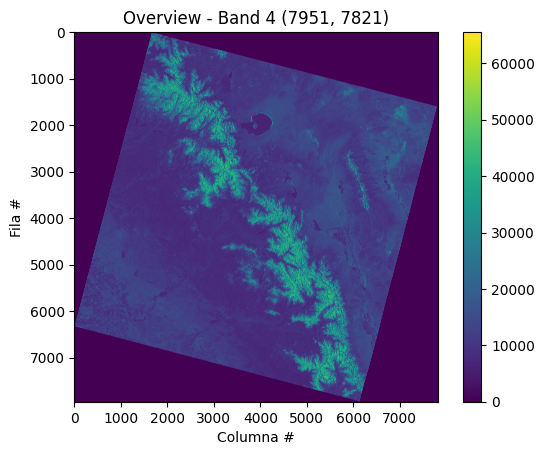

In [ ]:
#
# Ahora descargamos el dato desde AWS
#
#filepath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'
filepath = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'

#
# el dato se accede como un array numpy
#
with rasterio.open(filepath) as src:
#   oviews = src.overviews(1) # lista de overviews de mayor a menor
#   oview = oviews[-1] # elegimos el thumbnail más pequeño
#   print('Decimation factor= {}'.format(oview))
   #
   # NOTA: usamos una lectura del tipo 'decimated read'
   #  maś info en: http://rasterio.readthedocs.io/en/latest/topics/resampling.html
   #
   #thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
   thumbnail = src.read(1)

print('array type: ',type(thumbnail))
print(thumbnail)

#
# Mostramos el raster
#
plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Columna #')
plt.ylabel('Fila #')

Decíamos que era un objeto numpy, vamos a transformar algunos de los datos del array

In [ ]:
#with rasterio.open(filepath) as src:
    #oviews = src.overviews(1)
    #oview = oviews[-1]
    #print('Decimation factor= {}'.format(oview))
    #thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
#    thumbnail = src.read(1)
    #
    # Convertimos el array a enteros y asignamos los ceros a NA
    #
    #thumbnail = thumbnail.astype('f4')
    #thumbnail[thumbnail == 0] = np.nan

#plt.imshow(thumbnail)
#plt.colorbar()
#plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
#plt.xlabel('Column #')
#plt.ylabel('Row #')

## Representación interna de un raster
Antes de continuar, decíamos que era un array de tipo numpy, ¿cómo se representa internamente un raster?, vamos a ver la dimensión de la matriz

In [ ]:
thumbnail.shape

(7951, 7821)

In [ ]:
#
#  Pero también tiene una serie de componentes espaciales
#  el bounding box y el extent nos indican la dimensión del objeto y su ubicación
#
rasterio.open(filepath).bounds

BoundingBox(left=204285.0, bottom=4029585.0, right=438915.0, top=4268115.0)

In [ ]:
#
# Y tiene un CRS
#
rasterio.open(filepath).crs

CRS.from_epsg(32611)

En realidad es un array del paquete *numpy*, por tanto podemos trabajar con él como cualquier otra matriz. La única particular es que estamos hablando de un mosaico en el que dada tesela representa un área en la superficie de la tierra.

In [ ]:
#
# El raster es un array de np, podríamos hacer aritmética del raster simplemente
# con operaciones aritmticas del array
#
thumbnail

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

# Operaciones con rasters

## Computación con los datos raster
### Ejemplo de cálculo del índice de vegetación (NDVI)

El índice de vegetación de diferencia normalizada es un indicador simple que se puede utilizar para evaluar si el objetivo incluye vegetación saludable. Este cálculo utiliza dos bandas de un conjunto de datos de imágenes multiespectrales, las bandas roja e infrarroja cercana (NIR):

Para este tutorial, usaremos las bandas NIR y Red de una escena satelital de Landsat-8 sobre parte del valle central y Sierra Nevada en California. Usaremos conjuntos de datos de Nivel 1TP, imágenes ortorrectificadas proyectadas en mapas que contienen datos calibrados radiométricamente.

Bandas:
* **Rojo**: Banda 4
* **Infrarrojo cercano (NIR)**: banda 5

Debido a la longevidad de la misión Landsat y a que los diferentes sensores del satélite registran datos a diferentes resoluciones, estas bandas se almacenan individualmente como archivos ráster de una sola banda. Algunos otros rásteres pueden almacenar varias bandas en el mismo archivo.


In [ ]:
#
# Usamos una imagen de 2017
#
#date = '2017-06-16'
#url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/'
#redband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(4)

#with rasterio.open(url+redband) as src:
#    profile = src.profile
#    oviews = src.overviews(1) # list of overviews from biggest to smallest
#    oview = oviews[1]  # Use second-highest resolution overview
#    print('Factor de decimación= {}'.format(oview))
    #
    # El rater solo tiene una capa, elegimos la capa 1
    #
#    red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

# Mostramos la capa de Rojo
#plt.imshow(red)
#plt.colorbar()
#plt.title('{}\Rojo {}'.format(redband, red.shape))
#plt.xlabel('Columna #')
#plt.ylabel('Fila #')

Text(0, 0.5, 'Fila #')

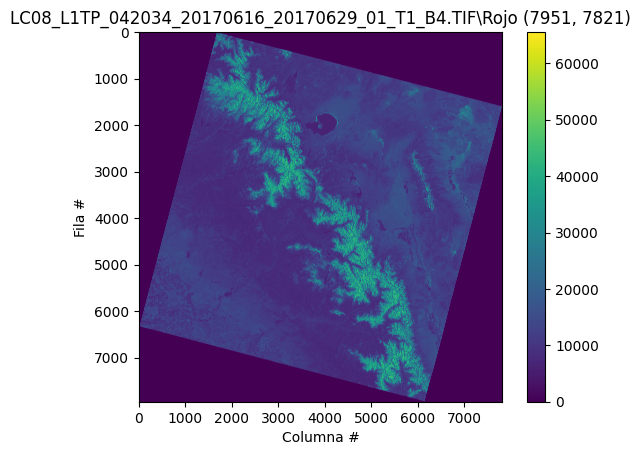

In [ ]:
url = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/'
redband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(4)

with rasterio.open(url+redband) as src:
  red = src.read(1)

# Mostramos la capa de Rojo
plt.imshow(red)
plt.colorbar()
plt.title('{}\Rojo {}'.format(redband, red.shape))
plt.xlabel('Columna #')
plt.ylabel('Fila #')

Y ahora la capa de infrarojo cercano

Text(0, 0.5, 'Fila #')

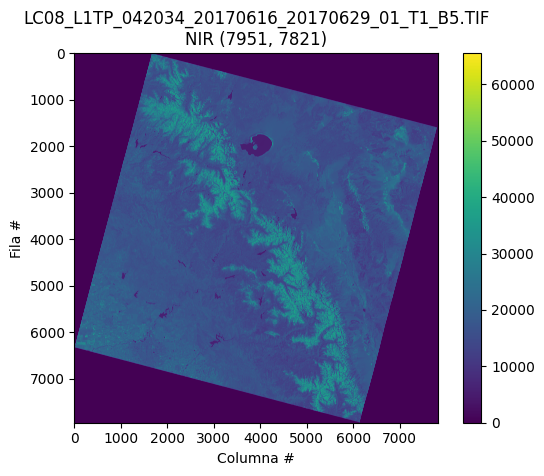

In [ ]:
nirband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(5)

#
# Descarga de capa de infrarrojo cercano
#
with rasterio.open(url + nirband) as src:
#    oviews = src.overviews(1) # list of overviews from biggest to smallest
#    oview = oviews[1]  # Use second-highest resolution overview
#    nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    nir = src.read(1)

plt.imshow(nir)
plt.colorbar()
plt.title('{}\nNIR {}'.format(nirband, nir.shape))
plt.xlabel('Columna #')
plt.ylabel('Fila #')

Ahora calculamos el índice de vegetación, como vemos la artimética entre capas se asemeja a las operaciones vectorizadas sobre una serie de un dataframe (en el proceso realizamos una conversión de los valores a enteros, [para más información](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.astype.html))


<ipython-input-12-d018d97130af>:10: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


Text(0, 0.5, 'Fila #')

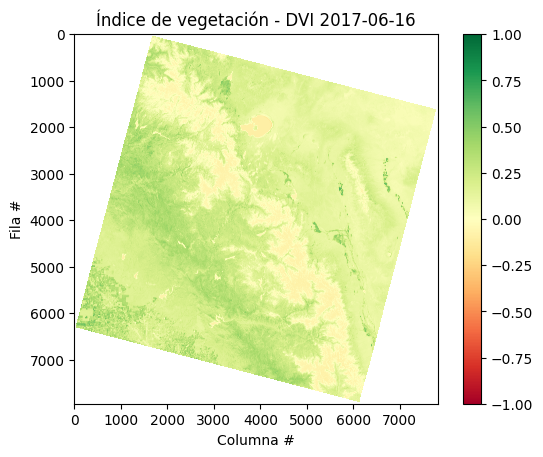

In [ ]:
#
# Cálculo de infrarrojo cercano
#
date = '2017-06-16'

def calculo_indice_de_vegetacion(nir,red):
    '''Crear NDVI a partir de arrays de enteros'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

ndvi = calculo_indice_de_vegetacion(nir, red)

#
# Mostramos el resultado
#
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('Índice de vegetación - DVI {}'.format(date))
plt.xlabel('Columna #')
plt.ylabel('Fila #')

Ahora hacemos un filtro por los resultado mostrando las regiones con mayor vegetación (DVI > 0.2), ya sabemos que es un objeto de tipo numpy

Text(0, 0.5, 'Row #')

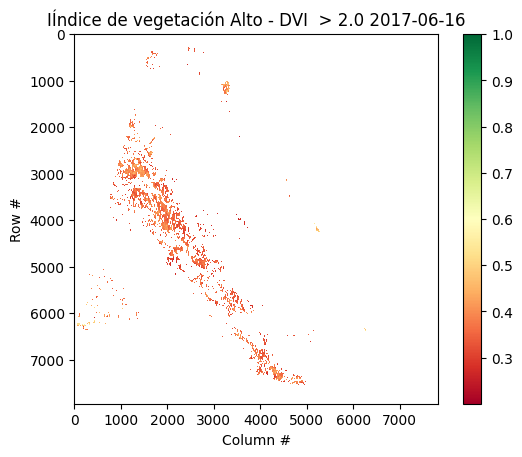

In [ ]:
#
# Filtramos las zonas con índice de vegetación alto >= 0.2
#
ndvi_high = ndvi.copy()
ndvi_high[ndvi_high < 0.2] = numpy.nan

plt.imshow(ndvi_high, cmap='RdYlGn')
plt.colorbar()
plt.title('IÍndice de vegetación Alto - DVI  > 2.0 {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

## Ejemplo de recorte con una capa vectorial (clip con una máscara)
La información del raster ser puede recortar con una capa vectorial con la operación **clip**. Para los recortes usaremos la librería [fiona para objetos vectoriales](https://fiona.readthedocs.io/en/latest/manual.html).


# Ejemplo con Madrid

En este ejercicio vamos a aplicar el análisis de información espacial y vectorial para calcular una media ponderada espacial de la antigüedad de los edificios en Madrid.

## Carga de datos de antigüedad

Partimos de un un raster con la antigüedad de cada finca y sus alrededores, el valor de cada punto indica la antigüedad de una construcción localizada en este punto.

![img](https://github.com/davidreyblanco/ml-training/raw/master/resources/ejemplo-age-raster.png)



Text(0, 0.5, 'Y #')

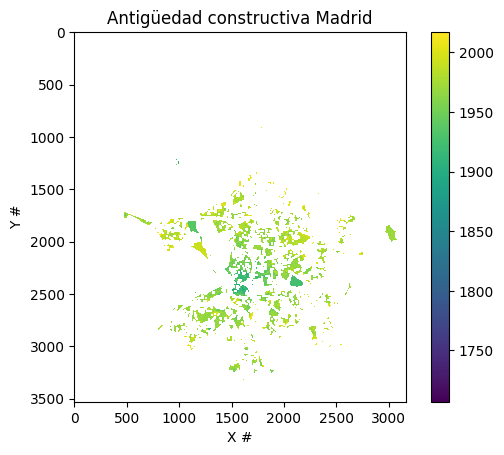

In [ ]:
#
# Carga de datos de antiguedad de las casas en Madrid
#
filepath = 'https://github.com/davidreyblanco/ml-training/raw/master/data/spatial/madrid-raster.tif'
building_age_src = rasterio.open(filepath)
building_age = building_age_src.read(1)

# Convertimos el dato a entero
building_age = building_age.astype('f4')

# Como en nuestro primer ejemplo, las celdas con ceros son NA
building_age[building_age < 1000] = np.nan

plt.imshow(building_age)
plt.colorbar()
plt.title('Antigüedad constructiva Madrid')
plt.xlabel('X #')
plt.ylabel('Y #')

### ¿Qué características tiene el raster?

In [ ]:
# ¿Qué límites tiene el raster (extent)?
building_age_src.bounds

BoundingBox(left=424409.9865, bottom=4463045.011, right=456054.9865, top=4498340.011)

In [ ]:
#¿Qué CRS tiene?
building_age_src.crs

CRS.from_epsg(25830)

## Carga de polígonos

<Axes: >

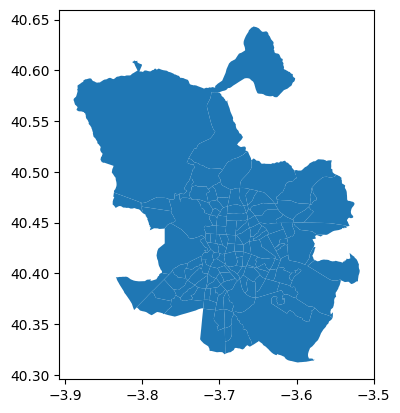

In [ ]:
#
# Cargamos los polígonos
#
madrid_barrios_path = 'https://raw.githubusercontent.com/davidreyblanco/ml-training/master/data/spatial/barrios-madrid_crs-4326.geojson'
madrid_barrios = geopandas.read_file(madrid_barrios_path)
#
# Los CRS no se incluyen en estos geojson por defecto se entiende que las coordenadas X,Y se expresan en latitudes y longitudes
# en este caso sin embargo tenemos la información en EPSG:4326 (en principio no es necesario porque es el valor por defecto)
# renombramos la columna de los barrios
#
madrid_barrios = madrid_barrios.set_crs(epsg = 4326, allow_override=True)
madrid_barrios = madrid_barrios.rename(columns={"DESBDT": "BARRIO"})

# Dibujamos el barrio
madrid_barrios.plot()

In [ ]:
#
# Reproyectamos a 25830 para que poder trabajar con el raster de antigüedad
#
madrid_barrios = madrid_barrios.to_crs(epsg=25830)

## Recorte del raster a través de una máscara

Vamos a calcular para cada zona dos medidas:

$age^{zona} = \frac{1}{N} \cdot \sum_{i=1}^{N}{age^{zona}_{i}}$

Y una medida de heterogeneidad medida de la zona (o dispersión si se quiere ver así) como el coeficiente de variación de Pearson:

$heterogeneidad^{zona} = 100 \cdot \frac{\sigma(zona)}{\mu(zona)}$


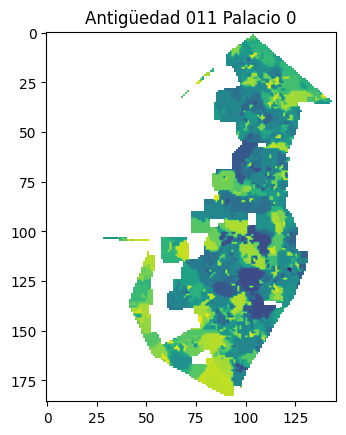

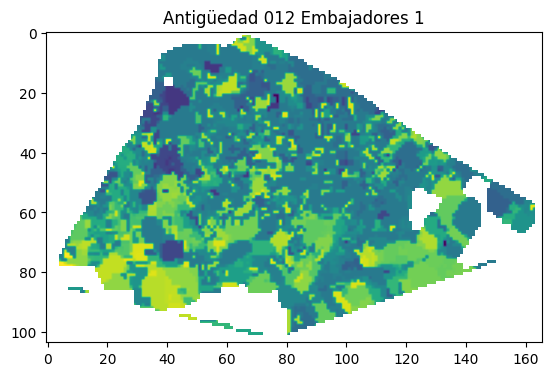

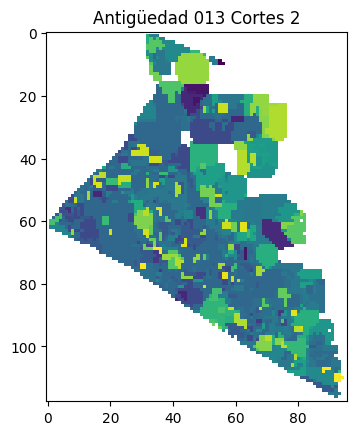

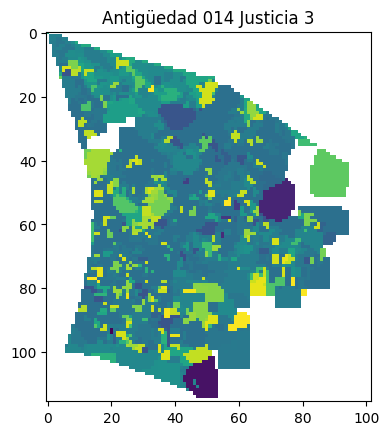

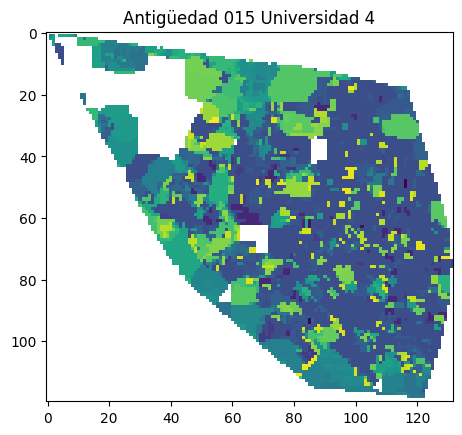

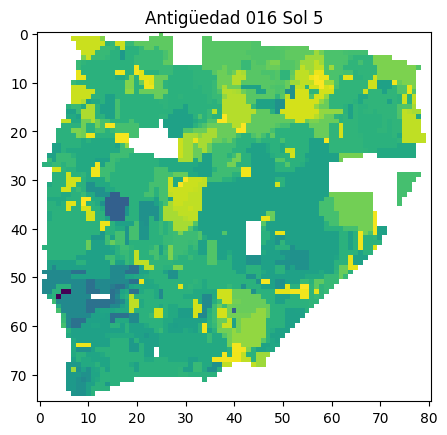

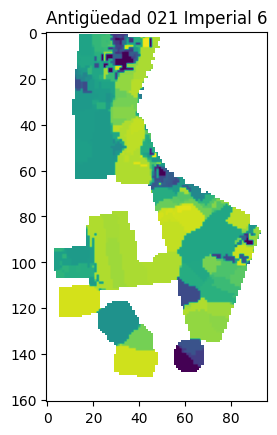

In [ ]:
#
# Aplicamos la máscara con la operación mask
# usamos la geometría
#
madrid_barrios['mean_age'] = numpy.nan
madrid_barrios['dispersion_age'] = numpy.nan
for i in range(0, len(madrid_barrios)):
  out_image, out_transform = rasterio.mask.mask(building_age_src,
                                              madrid_barrios[i:i+1]['geometry'],
                                              crop=True)
  # Como en nuestro primer ejemplo, las celdas con ceros son NA
  image = out_image[0].copy()
  image = image.astype('f4')
  image[image < 1000] = np.nan
  nombre_barrio = madrid_barrios[i:i+1]['BARRIO'].values[0]

  # Mostramos la figura (solo los 3 primeros)
  if i < 7:
    plt.figure()
    plt.imshow(image)
    plt.title('Antigüedad ' + nombre_barrio + ' ' + str(i))

  # Calculamos algunas medias para cada zona - Media
  #    y Coeficiente de variacion de Pearson como medida de dispersión
  mean_age = round(numpy.nanmean(image))
  dispersion_age = round(100 * numpy.nanvar(image) / numpy.nanmean(image))

  #
  # Actualizamos el registro en el GeoDataFrame
  #
  madrid_barrios.loc[madrid_barrios['BARRIO'] == nombre_barrio, 'mean_age'] = mean_age
  madrid_barrios.loc[madrid_barrios['BARRIO'] == nombre_barrio, 'dispersion_age'] = dispersion_age




In [ ]:
#
# Mostramos los 10 primeros registros de nuestro GeoDataFrame
#
madrid_barrios[1:10]

,CODBDT,GEOCODIGO,BARRIO,geometry,mean_age,dispersion_age
1,907410,079012,012 Embajadores,"POLYGON ((440369.414 4473937.265, 440363.243 4...",1928.0,87.0
2,907411,079013,013 Cortes,"POLYGON ((440872.261 4474491.446, 440862.624 4...",1921.0,67.0
3,907412,079014,014 Justicia,"POLYGON ((440920.098 4475481.025, 440916.598 4...",1920.0,67.0
4,907413,079015,015 Universidad,"POLYGON ((439586.519 4475753.323, 439575.978 4...",1927.0,61.0
5,907414,079016,016 Sol,"POLYGON ((440262.566 4474633.828, 440253.758 4...",1909.0,75.0
6,907415,079021,021 Imperial,"POLYGON ((439354.710 4472418.851, 439364.064 4...",1975.0,31.0
7,907416,079022,022 Las Acacias,"POLYGON ((440219.386 4471877.204, 440238.512 4...",1980.0,22.0
8,907417,079023,023 La Chopera,"POLYGON ((440777.610 4471200.436, 440783.361 4...",1956.0,18.0
9,907418,079024,024 Legazpi,"POLYGON ((442486.166 4471631.269, 442465.528 4...",1998.0,14.0


## Mostramos los resultados del análisis

Una vez calculados los valores a través de la agregación mostramos el valor de cada zona

<Axes: >

<Figure size 640x480 with 0 Axes>

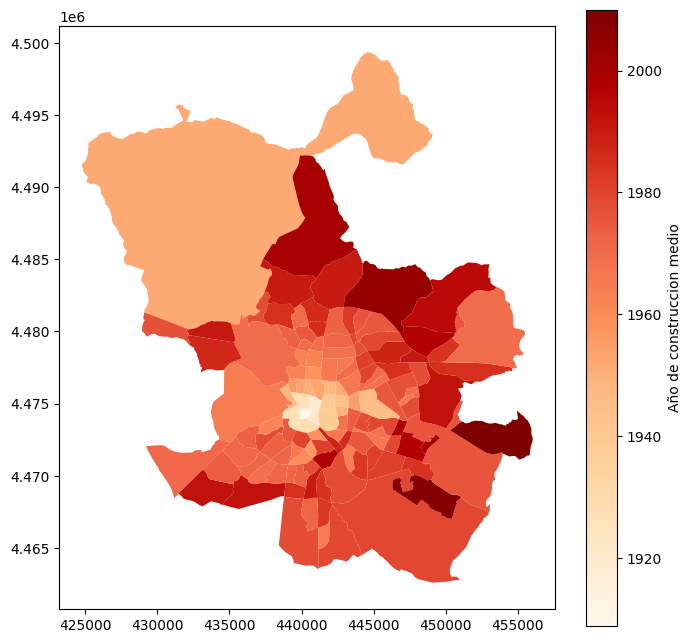

<Figure size 640x480 with 0 Axes>

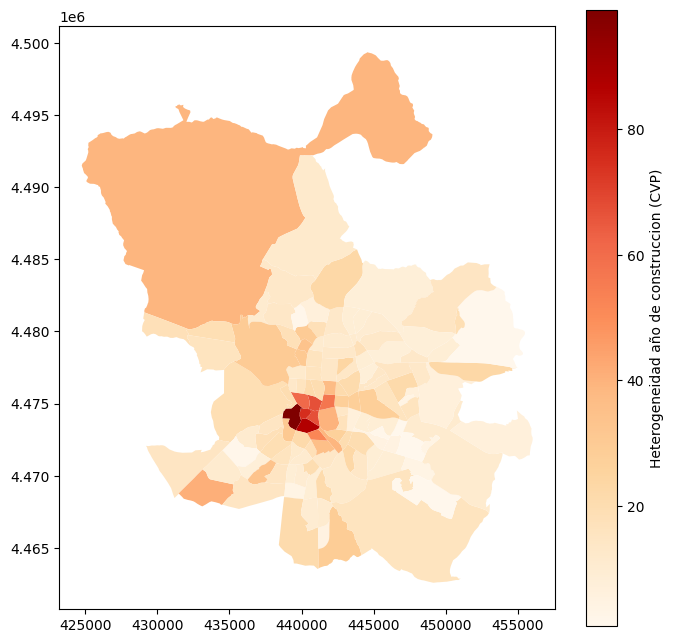

In [ ]:
#
# Mostramos el año de construcción medio por zona
#
plt.figure()
madrid_barrios.plot(column='mean_age',
           cmap='OrRd',
           figsize=(8, 8), legend=True,
           legend_kwds={'label': "Año de construccion medio", 'orientation': "vertical"})

#
# Mostramos la dispersión de antigüedades
#
plt.figure()
madrid_barrios.plot(column='dispersion_age',
           cmap='OrRd',
           figsize=(8, 8), legend=True,
           legend_kwds={'label': "Heterogeneidad año de construccion (CVP)", 'orientation': "vertical"})

In [ ]:
#
# Vemos los varrios con un nivel de dispersión mayor a 50
# ordenados de mayor a menor
#
madrid_barrios[madrid_barrios['dispersion_age'] > 50][['BARRIO', 'mean_age', 'dispersion_age']].sort_values(by=['dispersion_age'],
                                                                                                            ascending= False)

,BARRIO,mean_age,dispersion_age
0,011 Palacio,1926.0,99.0
1,012 Embajadores,1928.0,87.0
5,016 Sol,1909.0,75.0
2,013 Cortes,1921.0,67.0
3,014 Justicia,1920.0,67.0
4,015 Universidad,1927.0,61.0
19,041 Recoletos,1939.0,57.0
11,026 Palos de Moguer,1958.0,52.0


# Enlaces útiles
## Lecturas adicionales
* [Ejemplos con rasterio](https://geohackweek.github.io/raster/04-workingwithrasters/)
* [Reproyección de objetos raster](https://rasterio.readthedocs.io/en/latest/topics/reproject.html)
* [Resampling interesante a aplicar en procesos de reproyección](https://rasterio.readthedocs.io/en/latest/topics/resampling.html)
* [Proceso de información raster en python en EarthLab](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/)
* [Transformación afín](https://es.wikipedia.org/wiki/Transformaci%C3%B3n_af%C3%ADn)

## Recursos cartográficos:
> * [Repositorio imagen satelital Landsat 8 en Amazon](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-commercial-cloud-data-access
> * [Recursos cartográficos del IGN - CNIG](https://centrodedescargas.cnig.es/CentroDescargas/index.jsp)